# Part 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TollPlaza = pd.read_excel('TollPlaza.xlsx')
oppo_TollPlaza = pd.read_excel('oppo_TollPlaza.xlsx')

# This is 2200' W of Toll Plaza, has the best data


In [2]:
TollPlaza.columns = TollPlaza.columns.str.strip()
oppo_TollPlaza.columns = oppo_TollPlaza.columns.str.strip()

TollPlaza['Hour'] = pd.to_datetime(TollPlaza['Hour'])
oppo_TollPlaza['Hour'] = pd.to_datetime(oppo_TollPlaza['Hour'])

TollPlaza.set_index('Hour', inplace=True)
oppo_TollPlaza.set_index('Hour', inplace=True)

TollPlaza = TollPlaza.loc['2023-01-01':]
oppo_TollPlaza = oppo_TollPlaza.loc['2023-01-01':]

Baseline Total Delay: 20469.60 veh-hours
Post Full-Day Zipper Lane Shift Delay: 16429.15 veh-hours
Net Delay Reduction: 4040.45 veh-hours (19.74%)


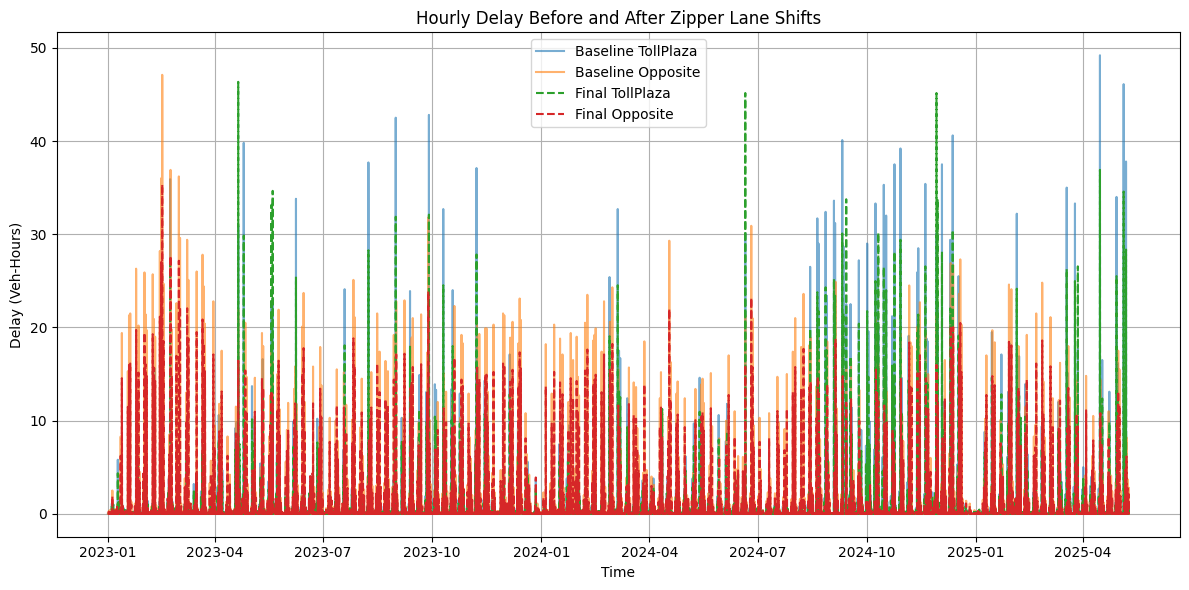

In [3]:
def total_delay(df):
    return df['Delay (V_t=60) (Veh-Hours)'].sum()

# Simulate lane shift for a given time window
def simulate_shift(df_main, df_oppo, start_time, end_time,
                   flow_column='Flow (Veh/Hour)',
                   delay_column='Delay (V_t=60) (Veh-Hours)',
                   reduction_factor=0.75,
                   increase_factor=1.50):
    df_main_sim = df_main.copy()
    df_oppo_sim = df_oppo.copy()

    # Create mask for the time window
    peak = (df_main_sim.index.time >= start_time) & (df_main_sim.index.time < end_time)

    # Simulate flow shift and delay adjustments
    df_main_sim.loc[peak, flow_column] += df_oppo_sim.loc[peak, flow_column]
    df_main_sim.loc[peak, delay_column] *= reduction_factor

    df_oppo_sim.loc[peak, flow_column] -= df_oppo_sim.loc[peak, flow_column]
    df_oppo_sim.loc[peak, delay_column] *= increase_factor

    return df_main_sim, df_oppo_sim

# Baseline delay
baseline_main = total_delay(TollPlaza)
baseline_oppo = total_delay(oppo_TollPlaza)
baseline_total = baseline_main + baseline_oppo

TollPlaza_morning, oppo_TollPlaza_morning = simulate_shift(
    TollPlaza, oppo_TollPlaza,
    start_time=pd.to_datetime("06:00").time(),
    end_time=pd.to_datetime("10:00").time()
)

oppo_final, TollPlaza_final = simulate_shift(
    oppo_TollPlaza_morning, TollPlaza_morning,
    start_time=pd.to_datetime("16:00").time(),
    end_time=pd.to_datetime("20:00").time()
)

# Final delay totals
delay_main_combined = total_delay(TollPlaza_final)
delay_oppo_combined = total_delay(oppo_final)
combined_total = delay_main_combined + delay_oppo_combined

# Print results
print(f"Baseline Total Delay: {baseline_total:.2f} veh-hours")
print(f"Post Full-Day Zipper Lane Shift Delay: {combined_total:.2f} veh-hours")
print(f"Net Delay Reduction: {baseline_total - combined_total:.2f} veh-hours ({100 * (baseline_total - combined_total) / baseline_total:.2f}%)")

# Optional plotting: Delay over time
plt.figure(figsize=(12, 6))
plt.plot(TollPlaza.index, TollPlaza['Delay (V_t=60) (Veh-Hours)'], label='Baseline TollPlaza', alpha=0.6)
plt.plot(oppo_TollPlaza.index, oppo_TollPlaza['Delay (V_t=60) (Veh-Hours)'], label='Baseline Opposite', alpha=0.6)
plt.plot(TollPlaza_final.index, TollPlaza_final['Delay (V_t=60) (Veh-Hours)'], label='Final TollPlaza', linestyle='--')
plt.plot(oppo_final.index, oppo_final['Delay (V_t=60) (Veh-Hours)'], label='Final Opposite', linestyle='--')

plt.title('Hourly Delay Before and After Zipper Lane Shifts')
plt.xlabel('Time')
plt.ylabel('Delay (Veh-Hours)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


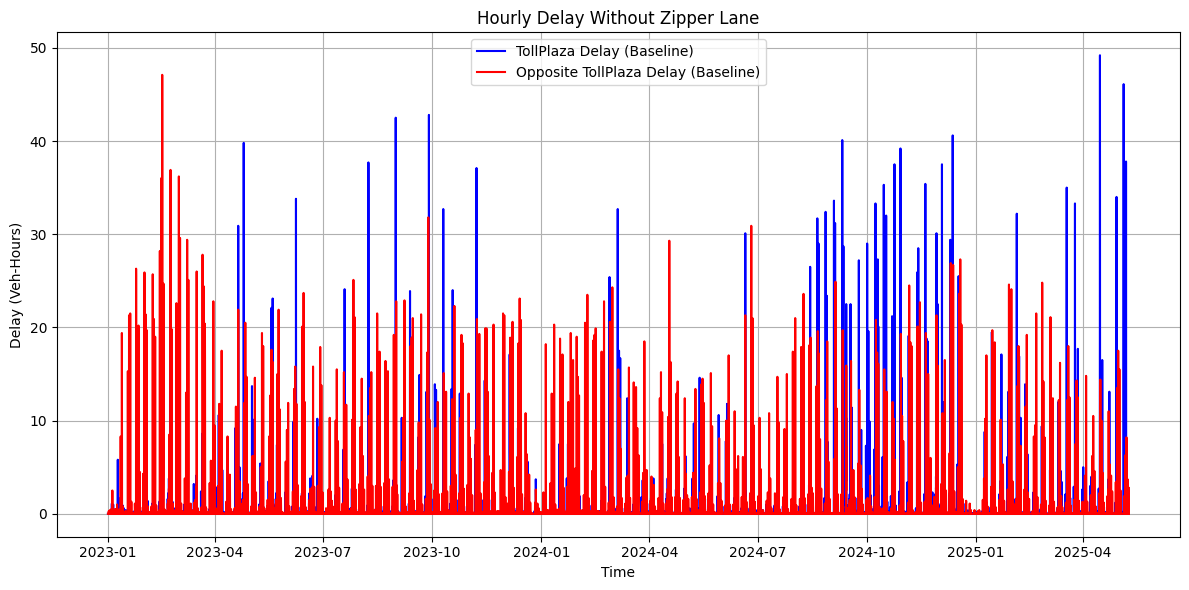

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(TollPlaza.index, TollPlaza['Delay (V_t=60) (Veh-Hours)'], label='TollPlaza Delay (Baseline)', color='blue')
plt.plot(oppo_TollPlaza.index, oppo_TollPlaza['Delay (V_t=60) (Veh-Hours)'], label='Opposite TollPlaza Delay (Baseline)', color='red')

plt.title('Hourly Delay Without Zipper Lane')
plt.xlabel('Time')
plt.ylabel('Delay (Veh-Hours)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


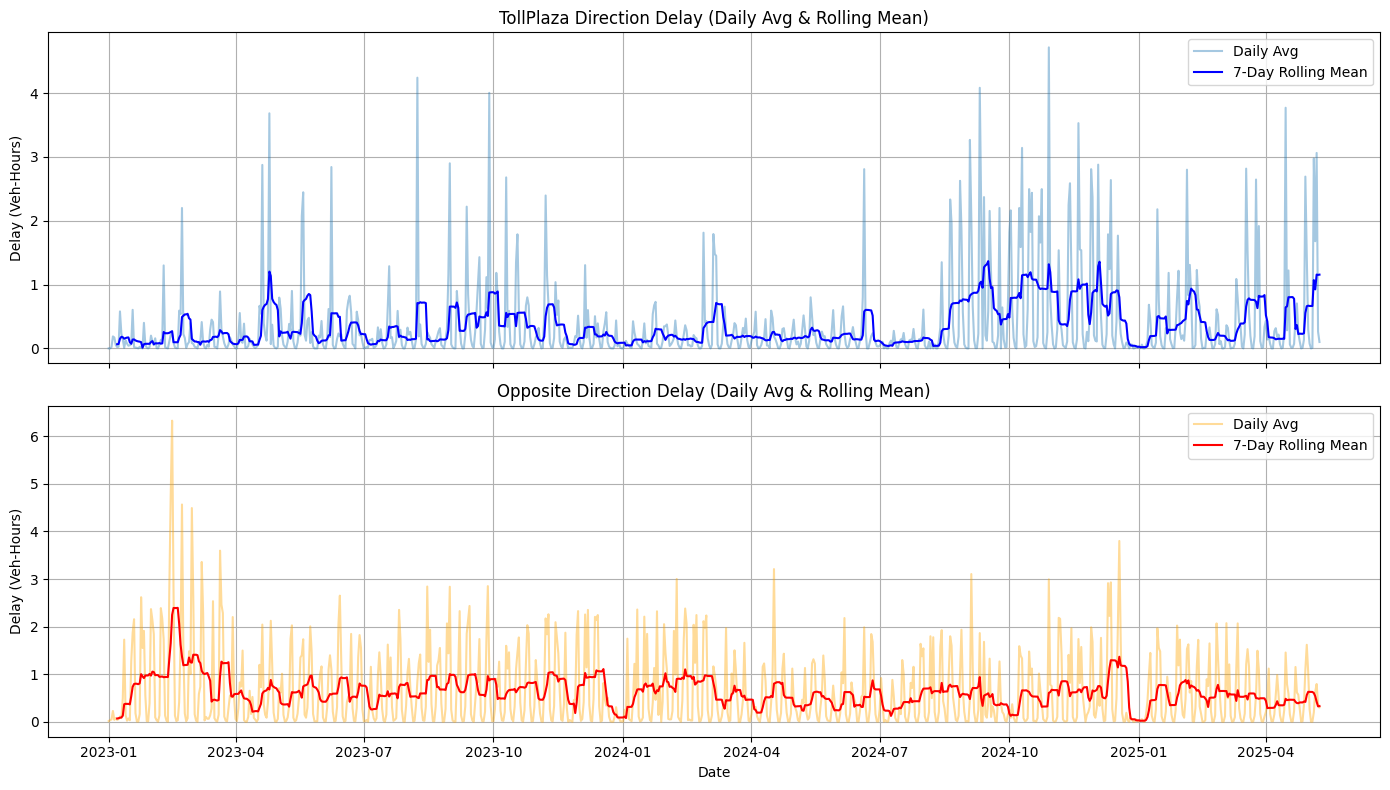

In [5]:
# Resample to daily average
TollPlaza_daily = TollPlaza.resample('D').mean()
oppo_daily = oppo_TollPlaza.resample('D').mean()

# Add 7-day rolling mean
TollPlaza_daily['Rolling Mean'] = TollPlaza_daily['Delay (V_t=60) (Veh-Hours)'].rolling(7).mean()
oppo_daily['Rolling Mean'] = oppo_daily['Delay (V_t=60) (Veh-Hours)'].rolling(7).mean()

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# TollPlaza plot
ax[0].plot(TollPlaza_daily.index, TollPlaza_daily['Delay (V_t=60) (Veh-Hours)'], alpha=0.4, label='Daily Avg')
ax[0].plot(TollPlaza_daily.index, TollPlaza_daily['Rolling Mean'], label='7-Day Rolling Mean', color='blue')
ax[0].set_title('TollPlaza Direction Delay (Daily Avg & Rolling Mean)')
ax[0].set_ylabel('Delay (Veh-Hours)')
ax[0].legend()
ax[0].grid(True)

# Opposite plot
ax[1].plot(oppo_daily.index, oppo_daily['Delay (V_t=60) (Veh-Hours)'], alpha=0.4, label='Daily Avg', color='orange')
ax[1].plot(oppo_daily.index, oppo_daily['Rolling Mean'], label='7-Day Rolling Mean', color='red')
ax[1].set_title('Opposite Direction Delay (Daily Avg & Rolling Mean)')
ax[1].set_ylabel('Delay (Veh-Hours)')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [6]:
time_steps = TollPlaza.index
n = len(time_steps)

actions = ['shift_EW', 'hold', 'shift_WE']
gamma = 0.95  # discount factor
shift_cost = 0.1

def get_reward(state_index, action):
    t = time_steps[state_index]
    base_TollPlaza = TollPlaza.loc[t, 'Delay (V_t=60) (Veh-Hours)']
    base_oppo = oppo_TollPlaza.loc[t, 'Delay (V_t=60) (Veh-Hours)']

    if action == 'hold':
        return -(base_TollPlaza + base_oppo)
    elif action == 'shift_EW':  # previously shift_to_TollPlaza
        return -(0.75 * base_TollPlaza + 1.50 * base_oppo) - shift_cost
    elif action == 'shift_WE':  # previously shift_to_oppo
        return -(1.50 * base_TollPlaza + 0.75 * base_oppo) - shift_cost

# per_vehicle_penalty = 1/60  # hours added to each vehicle
# def get_reward(state_index, action):
#     t     = time_steps[state_index]
#     base1 = TollPlaza.loc[t, 'Delay (V_t=60) (Veh-Hours)']
#     base2 = oppo_TollPlaza.loc[t, 'Delay (V_t=60) (Veh-Hours)']
#     flow  = TollPlaza.loc[t, 'Flow (Veh/Hour)']

#     # compute the raw delay as before
#     if action == 'hold':
#         delay_veh_hr = base1 + base2
#     elif action == 'shift_EW':
#         delay_veh_hr = 0.75*base1 + 1.50*base2
#     else:  # shift_WE
#         delay_veh_hr = 1.50*base1 + 0.75*base2

#     # add 0.5 hr *per* vehicle → in veh‑hours that is 0.5 * flow
#     if action != 'hold':
#         delay_veh_hr += per_vehicle_penalty * flow

#     return -delay_veh_hr



# Value iteration
V = np.zeros(n)
policy = []

for _ in range(50):
    new_V = np.zeros(n)
    for s in range(n):
        new_V[s] = max(
            get_reward(s, a) + (gamma * V[s + 1] if s < n - 1 else 0)
            for a in actions
        )
    if np.allclose(V, new_V):
        break
    V = new_V

# Extract policy
for s in range(n):
    best_action = max(
        actions,
        key=lambda a: get_reward(s, a) + (gamma * V[s + 1] if s < n - 1 else 0)
    )
    policy.append(best_action)

# Build schedule
optimal_schedule = pd.DataFrame({'Time': time_steps, 'Action': policy})
print(optimal_schedule.head(20))

                  Time Action
0  2023-01-01 00:00:00   hold
1  2023-01-01 01:00:00   hold
2  2023-01-01 02:00:00   hold
3  2023-01-01 03:00:00   hold
4  2023-01-01 04:00:00   hold
5  2023-01-01 05:00:00   hold
6  2023-01-01 06:00:00   hold
7  2023-01-01 07:00:00   hold
8  2023-01-01 08:00:00   hold
9  2023-01-01 09:00:00   hold
10 2023-01-01 10:00:00   hold
11 2023-01-01 11:00:00   hold
12 2023-01-01 12:00:00   hold
13 2023-01-01 13:00:00   hold
14 2023-01-01 14:00:00   hold
15 2023-01-01 15:00:00   hold
16 2023-01-01 16:00:00   hold
17 2023-01-01 17:00:00   hold
18 2023-01-01 18:00:00   hold
19 2023-01-01 19:00:00   hold


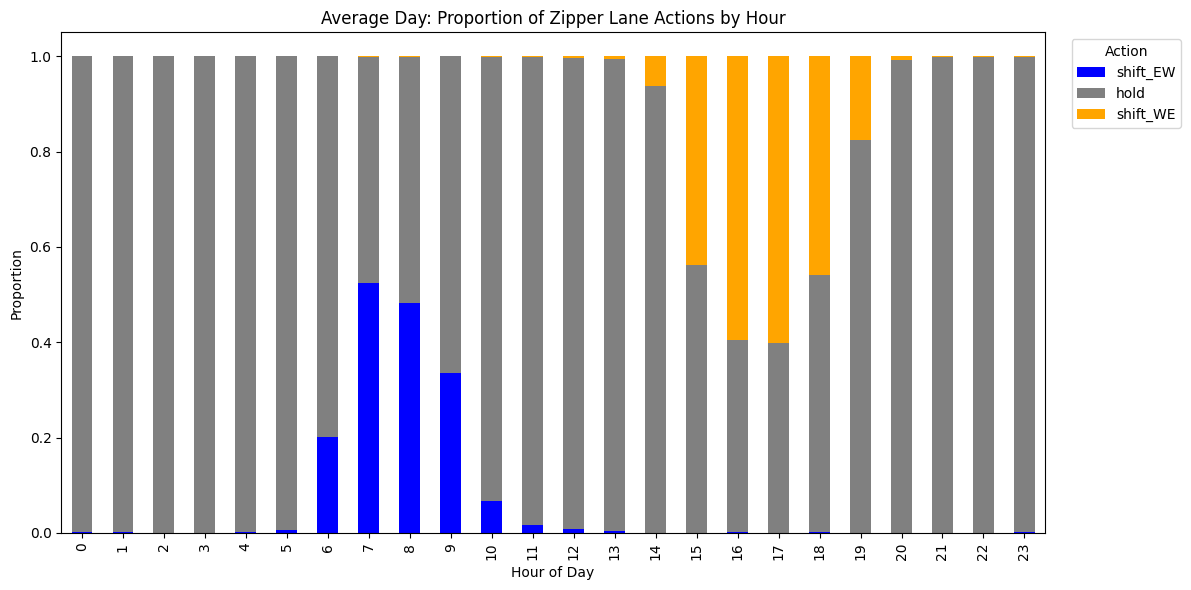

In [7]:
optimal_schedule['Time'] = pd.to_datetime(optimal_schedule['Time'])

# Extract hour
optimal_schedule['Hour'] = optimal_schedule['Time'].dt.hour

# Count occurrences of each action at each hour
hourly_action_counts = optimal_schedule.groupby(['Hour', 'Action']).size().unstack(fill_value=0)

# Normalize to get proportions
hourly_action_props = hourly_action_counts.div(hourly_action_counts.sum(axis=1), axis=0)

# Reorder columns if needed
action_order = ['shift_EW', 'hold', 'shift_WE']
hourly_action_props = hourly_action_props[action_order]

# Plot: Stacked bar chart
colors = {'hold': 'gray', 'shift_EW': 'blue', 'shift_WE': 'orange'}
hourly_action_props.plot(kind='bar', stacked=True, color=[colors[a] for a in action_order], figsize=(12, 6))

plt.title('Average Day: Proportion of Zipper Lane Actions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion')
plt.legend(title='Action', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


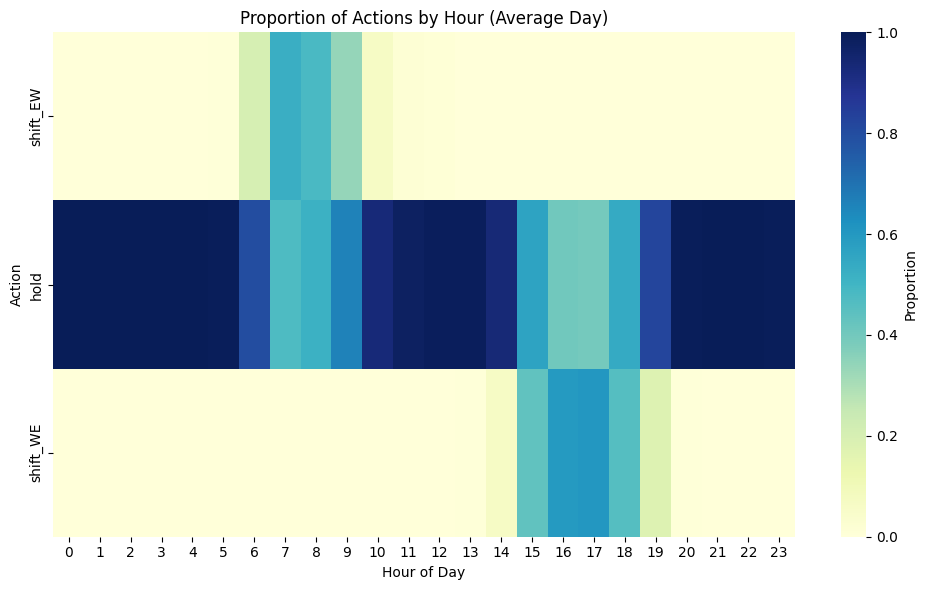

In [8]:
action_hourly_counts = optimal_schedule.groupby(['Hour', 'Action']).size().unstack(fill_value=0)

action_hourly_props = action_hourly_counts.div(action_hourly_counts.sum(axis=1), axis=0)

action_order = ['shift_EW', 'hold', 'shift_WE']
action_hourly_props = action_hourly_props.reindex(columns=action_order, fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(action_hourly_props.T,  cmap='YlGnBu', cbar_kws={'label': 'Proportion'})
plt.title('Proportion of Actions by Hour (Average Day)')
plt.xlabel('Hour of Day')
plt.ylabel('Action')
plt.tight_layout()
plt.show()


Morning Peak Delay Savings: 1403.00 veh-hours
Evening Peak Delay Savings: 2621.60 veh-hours
Total Delay Savings: 4337.57 veh-hours


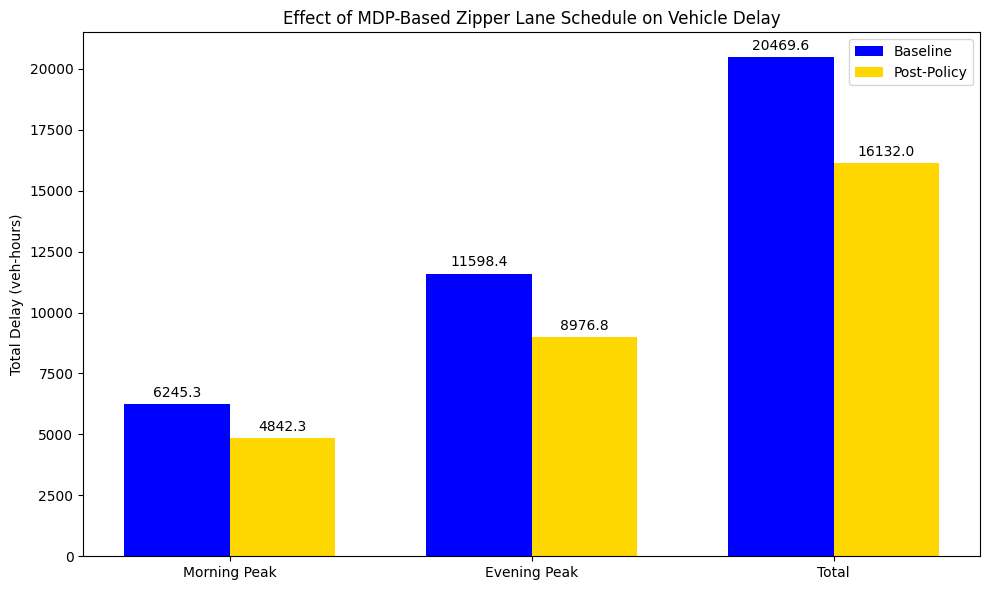

In [9]:
# ---------------------------
# Apply the MDP-Based Schedule to Modify Delay
# ---------------------------
TollPlaza_sched = TollPlaza.copy()
oppo_sched = oppo_TollPlaza.copy()

# Apply MDP actions
for i, row in optimal_schedule.iterrows():
    t = row['Time']
    act = row['Action']

    if act == 'shift_EW':  # shift toward TollPlaza
        TollPlaza_sched.loc[t, 'Delay (V_t=60) (Veh-Hours)'] *= 0.75
        oppo_sched.loc[t, 'Delay (V_t=60) (Veh-Hours)'] *= 1.50
    elif act == 'shift_WE':  # shift toward opposing direction
        TollPlaza_sched.loc[t, 'Delay (V_t=60) (Veh-Hours)'] *= 1.50
        oppo_sched.loc[t, 'Delay (V_t=60) (Veh-Hours)'] *= 0.75
    # 'hold' does nothing

# ---------------------------
# Compute Delay Sums for Periods
# ---------------------------
def is_in_window(index, start, end):
    t = index.time()
    return start <= t < end

morning_start = pd.to_datetime("07:00").time()
morning_end = pd.to_datetime("10:00").time()
evening_start = pd.to_datetime("15:30").time()
evening_end = pd.to_datetime("19:00").time()

# Apply masks
morning_mask = TollPlaza.index.map(lambda t: is_in_window(t, morning_start, morning_end))
evening_mask = TollPlaza.index.map(lambda t: is_in_window(t, evening_start, evening_end))

# Sum delays
baseline_morning = TollPlaza.loc[morning_mask, 'Delay (V_t=60) (Veh-Hours)'].sum() + \
                   oppo_TollPlaza.loc[morning_mask, 'Delay (V_t=60) (Veh-Hours)'].sum()
baseline_evening = TollPlaza.loc[evening_mask, 'Delay (V_t=60) (Veh-Hours)'].sum() + \
                   oppo_TollPlaza.loc[evening_mask, 'Delay (V_t=60) (Veh-Hours)'].sum()
baseline_total = TollPlaza['Delay (V_t=60) (Veh-Hours)'].sum() + \
                 oppo_TollPlaza['Delay (V_t=60) (Veh-Hours)'].sum()

post_morning = TollPlaza_sched.loc[morning_mask, 'Delay (V_t=60) (Veh-Hours)'].sum() + \
               oppo_sched.loc[morning_mask, 'Delay (V_t=60) (Veh-Hours)'].sum()
post_evening = TollPlaza_sched.loc[evening_mask, 'Delay (V_t=60) (Veh-Hours)'].sum() + \
               oppo_sched.loc[evening_mask, 'Delay (V_t=60) (Veh-Hours)'].sum()
post_total = TollPlaza_sched['Delay (V_t=60) (Veh-Hours)'].sum() + \
             oppo_sched['Delay (V_t=60) (Veh-Hours)'].sum()

# ---------------------------
# Print Delay Savings
# ---------------------------
morning_savings = baseline_morning - post_morning
evening_savings = baseline_evening - post_evening
total_savings = baseline_total - post_total

print(f"Morning Peak Delay Savings: {morning_savings:.2f} veh-hours")
print(f"Evening Peak Delay Savings: {evening_savings:.2f} veh-hours")
print(f"Total Delay Savings: {total_savings:.2f} veh-hours")

# ---------------------------
# Plot Before vs After Comparison
# ---------------------------
labels = ['Morning Peak', 'Evening Peak', 'Total']
baseline_values = [baseline_morning, baseline_evening, baseline_total]
post_values = [post_morning, post_evening, post_total]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='blue')
bars2 = ax.bar(x + width/2, post_values, width, label='Post-Policy', color='gold')

ax.set_ylabel('Total Delay (veh-hours)')
ax.set_title('Effect of MDP-Based Zipper Lane Schedule on Vehicle Delay')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


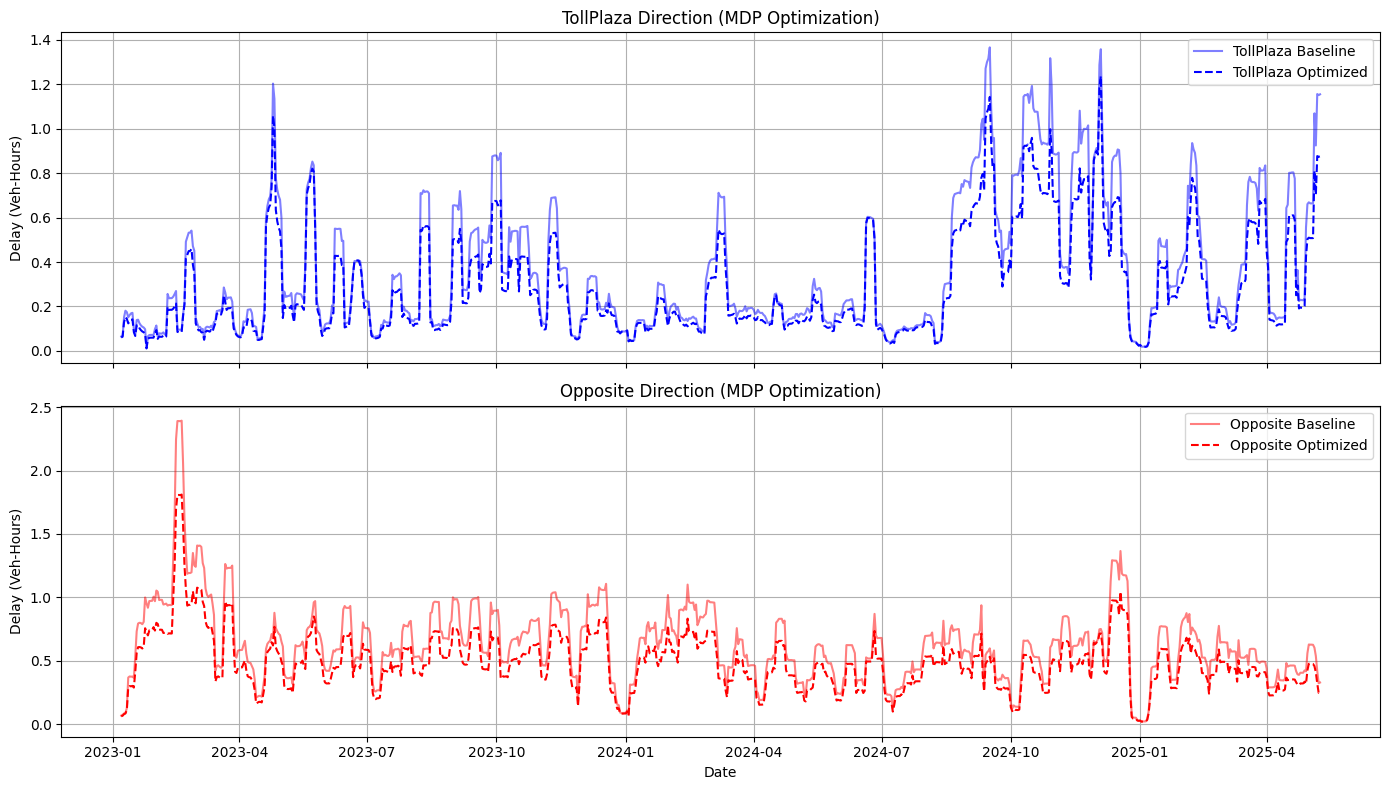

In [10]:
# Resample both baseline and optimized to daily means
TollPlaza_daily_base = TollPlaza.resample('D').mean()
TollPlaza_daily_opt = TollPlaza_sched.resample('D').mean()

oppo_daily_base = oppo_TollPlaza.resample('D').mean()
oppo_daily_opt = oppo_sched.resample('D').mean()

# Apply 7-day rolling mean
TollPlaza_daily_base['Rolling'] = TollPlaza_daily_base['Delay (V_t=60) (Veh-Hours)'].rolling(7).mean()
TollPlaza_daily_opt['Rolling'] = TollPlaza_daily_opt['Delay (V_t=60) (Veh-Hours)'].rolling(7).mean()

oppo_daily_base['Rolling'] = oppo_daily_base['Delay (V_t=60) (Veh-Hours)'].rolling(7).mean()
oppo_daily_opt['Rolling'] = oppo_daily_opt['Delay (V_t=60) (Veh-Hours)'].rolling(7).mean()

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# TollPlaza direction
ax[0].plot(TollPlaza_daily_base.index, TollPlaza_daily_base['Rolling'], label='TollPlaza Baseline', color='blue', alpha=0.5)
ax[0].plot(TollPlaza_daily_opt.index, TollPlaza_daily_opt['Rolling'], label='TollPlaza Optimized', color='blue', linestyle='--')
ax[0].set_ylabel('Delay (Veh-Hours)')
ax[0].set_title('TollPlaza Direction (MDP Optimization)')
ax[0].legend()
ax[0].grid(True)

# Opposite direction
ax[1].plot(oppo_daily_base.index, oppo_daily_base['Rolling'], label='Opposite Baseline', color='red', alpha=0.5)
ax[1].plot(oppo_daily_opt.index, oppo_daily_opt['Rolling'], label='Opposite Optimized', color='red', linestyle='--')
ax[1].set_ylabel('Delay (Veh-Hours)')
ax[1].set_xlabel('Date')
ax[1].set_title('Opposite Direction (MDP Optimization)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
